# 3 - Analysis of DVL Data
Finally, we want to evaluate the quality of the glider's merged dataset, with the ultimate goal of creating velocity profiles. 

In [16]:
import pandas as pd
import xarray as xr
import numpy as np

In [17]:
# For this example we will be using CP05MOAS-GL379 D00008, which was deployed at the Pioneer NES array from 2019-09-27 to 2019-11-19.
refdes = 'CP05MOAS-GL379-01-ADCPAM000'
eng_refdes = 'CP05MOAS-GL379-00-ENG000000'
deployment = 8

In [18]:
dep_str = f"{deployment:04d}"  # always 4 digits, e.g., '0008'
glider_name = '-'.join(refdes.split('-')[:2]) # shorten ref des to get glider name

In [19]:
# Load in the merged glider data set 
glider = xr.open_dataset(f"../data/processed/{glider_name}.deployment{dep_str}.merged.nc")

sh: 1: getfattr: not found


## *Plotting the track of Glider 379*
Plotting the track:
- ensures that the glider stuck to the preprogrammed waypoints
- shows us which moorings the glider passes by for future comparison

In [20]:
# Load in mooring data
moorings = pd.read_csv("../data/external/mooring_locations.csv")

/opt/conda/envs/glider_dvl_analysis/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/glider_dvl_analysis/lib/python3.10/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


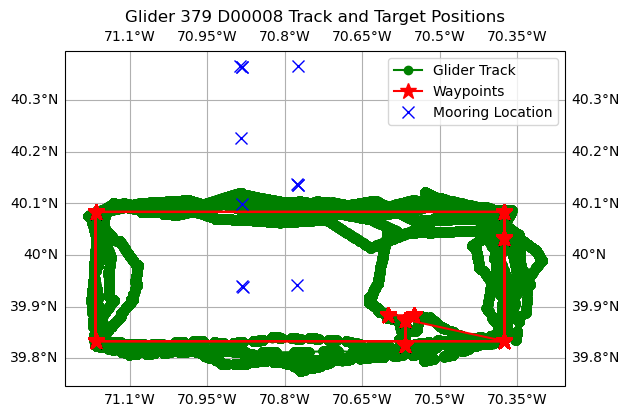

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Extract glider waypoints, filtering out invalid (0.0) entries
waypoint_lon = glider['waypoint_lon']
filtered_waypoint_lon = waypoint_lon.where(waypoint_lon != 0.0, drop=True)
waypoint_lat = glider['waypoint_lat']
filtered_waypoint_lat = waypoint_lat.where(waypoint_lat != 0.0, drop=True)

# Extract glider positions
track_lon = glider['glider_precise_lon']
track_lat = glider['glider_precise_lat']

# Get Pioneer NES mooring locations
pioneer_moorings = moorings[moorings['mooring'].str.startswith('CP0')]
pioneer_lat = pioneer_moorings['lat']
pioneer_lon = pioneer_moorings['lon']

# Plot the glider track and waypoints
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Glider 379 D00008 Track and Target Positions')

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

ax.plot(track_lon, track_lat, color='green', marker='o', label='Glider Track', transform=ccrs.PlateCarree())
ax.plot(filtered_waypoint_lon, filtered_waypoint_lat, color='red', marker='*', markersize=12, label='Waypoints', transform=ccrs.PlateCarree())

# Plot the mooring locations
ax.plot(pioneer_lon, pioneer_lat, marker='x', markersize = 8, linestyle='None', color='blue', label='Mooring Location', transform=ccrs.PlateCarree())

ax.legend()
plt.tight_layout()
plt.show()

## *Subsetting the track*
Our analysis will focus on the northern portion of the track.

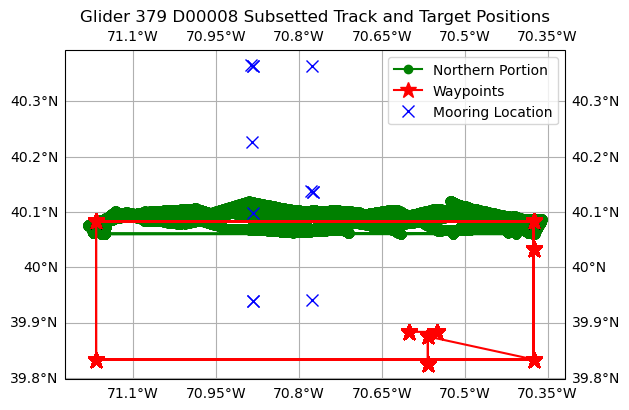

In [22]:
# Subset the data based on a latitude threshold
target_lat = 40.09
tolerance = 0.03

mask = abs(glider['glider_precise_lat'] - target_lat) <= tolerance
filtered_track = {
    var: glider[var].where(mask, drop=True)
    for var in ['glider_precise_lon', 'glider_precise_lat']
}

# Plot the glider track and waypoints
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Glider 379 D00008 Subsetted Track and Target Positions')

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

ax.plot(filtered_track['glider_precise_lon'], filtered_track['glider_precise_lat'], color='green', marker='o', label='Northern Portion', transform=ccrs.PlateCarree())
ax.plot(filtered_waypoint_lon, filtered_waypoint_lat, color='red', marker='*', markersize=12, label='Waypoints', transform=ccrs.PlateCarree())

ax.plot(pioneer_lon, pioneer_lat, marker='x', markersize = 8, linestyle='None', color='blue', label='Mooring Location', transform=ccrs.PlateCarree())

ax.legend()
plt.tight_layout()
plt.show()

# Close the dataset
glider.close()

## *Getting one transect and one dive*
Throughout the northern portion, the glider makes multiple east–west passes. We define each completed pass as a transect.

We will focus on one of these transects (occurring from 2019-10-05 to 2019-10-08), which is composed of numerous dives. We will also analyze a single dive from this transect. 

sh: 1: getfattr: not found


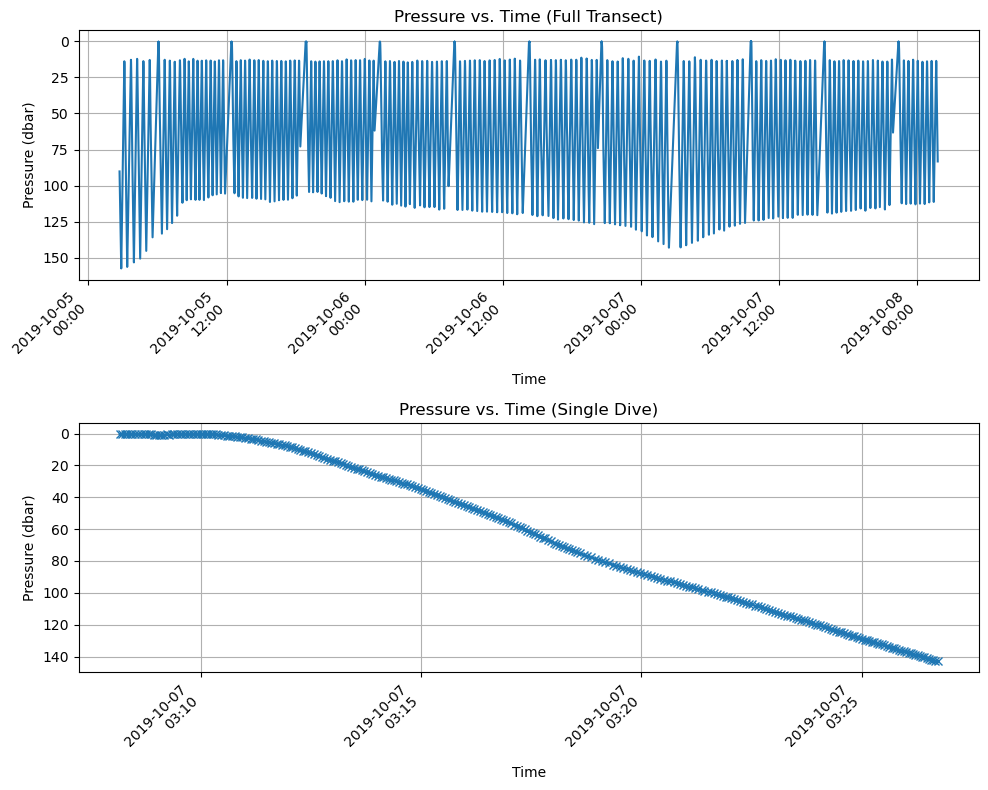

In [23]:
import matplotlib.dates as mdates

# Subset the data by transect date
transect_start = '2019-10-05T02:42:00'
transect_end = '2019-10-08T01:47:00'
transect_subset = glider.sel(time=slice(transect_start, transect_end))

# Extract time and pressure values for transect
transect_times = pd.to_datetime(transect_subset['time'].values).to_pydatetime()
transect_pressure = transect_subset['non_zero_pressure'].values

# Subset the data by dive date
dive_start = '2019-10-07T03:05:00'
dive_end = '2019-10-07T03:35:00'
dive_subset = glider.sel(time=slice(dive_start, dive_end))

# Extract time and pressure values for dive
dive_times = pd.to_datetime(dive_subset['time'].values).to_pydatetime()
dive_pressure = dive_subset['non_zero_pressure'].values

# Plotting both the transect and dive data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Transect
c1 = ax1.plot(transect_times, transect_pressure)
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Time')
ax1.set_title('Pressure vs. Time (Full Transect)')
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True)

# Dive
c2 = ax2.plot(dive_times, dive_pressure, marker = 'x', markersize = 6)
ax2.set_xlabel('Time')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_title('Pressure vs. Time (Single Dive)')
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()

## *Investigating Quality Control Parameters*
Having extracted a single dive from the dataset, we can plot correlation magnitudes and quality control flags for various points within the dive. This will enable us to establish a quality threshold for subsequent analysis.

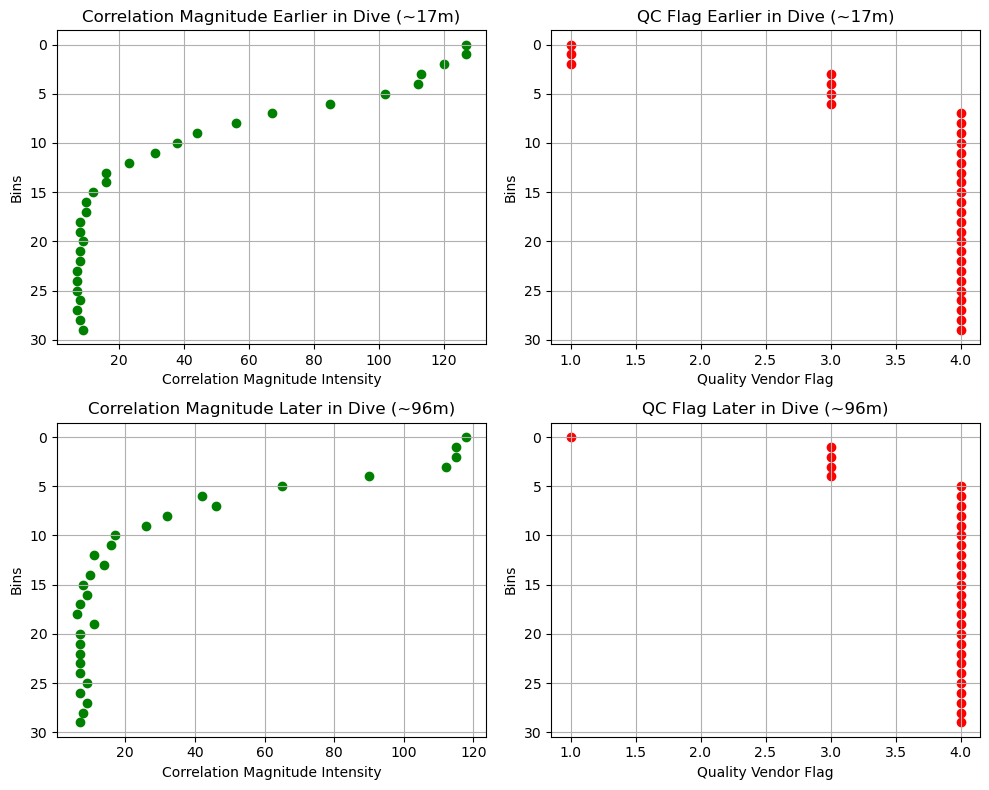

In [24]:
# Selecting a data point early in the single dive above
target_time1 = '2019-10-07T03:13:00'       
dive_profile1 = dive_subset.sel(time=target_time1, method='nearest')

# Selecting a data point later in the single dive above
target_time2 = '2019-10-07T03:21:00'
dive_profile2 = dive_subset.sel(time=target_time2, method='nearest')

# Extracting correlation magnitude beam and QC vendor flag for these points
bins1 = dive_profile1['bin'].values
depth1 = int(dive_profile1['non_zero_pressure'].values.round())
correlation1 = dive_profile1['correlation_magnitude_beam2'].values
QC1 = dive_profile1['vendor_qc_flag'].values

bins2 = dive_profile2['bin'].values
depth2 = int(dive_profile2['non_zero_pressure'].values.round())
correlation2 = dive_profile2['correlation_magnitude_beam2'].values
QC2 = dive_profile2['vendor_qc_flag'].values

# Plotting these parameters for each bin
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

c1 = ax1.scatter(correlation1, bins1, color='green')
ax1.set_ylabel('Bins')
ax1.set_xlabel('Correlation Magnitude Intensity')
ax1.set_title('Correlation Magnitude Earlier in Dive (~{}m)'.format(depth1))
ax1.invert_yaxis()
ax1.grid(True)

c2 = ax2.scatter(QC1, bins1, color='red')
ax2.set_xlabel('Quality Vendor Flag')
ax2.set_ylabel('Bins')
ax2.set_title('QC Flag Earlier in Dive (~{}m)'.format(depth1))
ax2.invert_yaxis()
ax2.grid(True)

c3 = ax3.scatter(correlation2, bins2, color='green')
ax3.set_ylabel('Bins')
ax3.set_xlabel('Correlation Magnitude Intensity')
ax3.set_title('Correlation Magnitude Later in Dive (~{}m)'.format(depth2))
ax3.invert_yaxis()
ax3.grid(True)

c4 = ax4.scatter(QC2, bins2, color='red')
ax4.set_xlabel('Quality Vendor Flag')
ax4.set_ylabel('Bins')
ax4.set_title('QC Flag Later in Dive (~{}m)'.format(depth2))
ax4.invert_yaxis()
ax4.grid(True)

plt.tight_layout()
plt.show()

Correlation magnitude intensities below 50 or 60 dB are indicative of bad data. QC vendor flags of 4 are indicative of bad data, flags of 3 are suspect, and flags of 1 indicate good data.

These graphs show that
- Correlation magnitude intensities drop around the same bin as the QC flag goes to 4
- Less good data is available later in dives

From these graphs, we determined our quality control threshold: <ins>*masking any data with a QC vendor flag of 4*</ins>

## *Applying the QC Mask to the Velocity Data*
Now that we established our quality threshold, we want to mask out any velocity measurements associated with bad data.

To do so, we would need to copy our original dataset and apply the mask.

In [26]:
import netCDF4

# Open glider dataset
glider = xr.open_dataset(f"../data/processed/{glider_name}.deployment{dep_str}.merged.nc")

# Create mask based on QC flag
qc_mask = glider['vendor_qc_flag'] !=4

# Apply mask to northward and eastward velocities
NV_clean_nan = glider['northward_seawater_velocity'].where(qc_mask)
EV_clean_nan = glider['eastward_seawater_velocity'].where(qc_mask)

# Copy original dataset, filtering out bad velocity data
clean_velocities = glider.copy()

clean_velocities['northward_seawater_velocity'] = NV_clean_nan
clean_velocities['eastward_seawater_velocity'] = EV_clean_nan

# Create a new, "clean" dataset
clean_velocities.to_netcdf(
    f"../data/processed/{glider_name}.deployment{dep_str}.clean_velocities.nc",
    format="NETCDF4",
    engine="netcdf4"
)

sh: 1: getfattr: not found


## *Creating Depth-Averaged Velocity Profiles*
With our quality-controlled dataset, we can now create velocity profiles from the glider.

This is a multi-step process which includes:
- Ploting good velocity measurements over dives and transects (chosing dive nearest to Pioneer NES mooring CP02PMCO for eventual comparison)
- Grouping data into bins of equal depth
- Calculating the means and standard deviations in the bins
- Plotting the velocities against depth

In [27]:
# Open "cleaned" dataset
clean_glider = xr.open_dataset(f"../data/processed/{glider_name}.deployment{dep_str}.clean_velocities.nc")

sh: 1: getfattr: not found


In [37]:
# Load in glider coordinates
glider_lat = clean_glider['glider_precise_lat'].values
glider_lon = clean_glider['glider_precise_lon'].values

# Extract CP02PMCO's position 
target_mooring = pioneer_moorings[pioneer_moorings['mooring'] == 'CP02PMCO']
lat_target = target_mooring['lat'].values[0]
lon_target = target_mooring['lon'].values[0]

# Compute Euclidean distance (approximate, good for small areas)
distance = np.sqrt((glider_lat - lat_target)**2 + (glider_lon - lon_target)**2)
flat_distance = distance.flatten()
mean_distance = flat_distance.mean()

# Find the index where the glider is closest to the mooring
closest_index = np.argmin(distance)

# Get the corresponding time
closest_time = clean_glider['time'].values[closest_index]

print(f"The glider was closest to the mooring at {closest_time}")
print(f"The glider was on average {mean_distance:.3f} meters away from the mooring")

The glider was closest to the mooring at 2019-10-23T09:56:35.320000172
The glider was on average 0.350 meters away from the mooring


In [38]:
# Extracting good data from a dive when the glider is near the mooring
start_dive = '2019-10-23T09:35:00'
end_dive = '2019-10-23T10:05:00'
subset_dive = clean_glider.sel(time=slice(start_dive, end_dive))

times_dive = pd.to_datetime(subset_dive['time'].values).to_pydatetime()

# Extracting other data
NV_dive = subset_dive['northward_seawater_velocity'].values
EV_dive = subset_dive['eastward_seawater_velocity'].values
pressure_dive = subset_dive['non_zero_pressure'].values
depth_dive = subset_dive['depth_from_pressure'].values

# Create 30 bins, each bin 2 meters deep
bin_depths_dive = np.arange(1, 60, 2)

# Calculate actual depth for bins and depth from pressure values
actual_depth_dive = depth_dive[:, np.newaxis] + bin_depths_dive[np.newaxis, :]

# Original NaN masks
nan_NV = np.isnan(NV_dive)
nan_EV = np.isnan(EV_dive)

# Copy the original mask to modify
nan_mask_corrected = nan_NV.copy()

# Iterate over time steps (columns)
for i in range(nan_NV.shape[1]):
    col = nan_NV[:, i]
    
    # Find first NaN index in the column
    nan_indices = np.where(col)[0]
    
    if nan_indices.size > 0:
        first_nan_idx = nan_indices[0]
        
        # Mask everything *deeper* (i.e., after the first NaN)
        nan_mask_corrected[first_nan_idx+1:, i] = True

# Apply bottom hit masking
final_mask = np.logical_or(nan_mask_corrected, actual_depth_dive > 140)

# Define depth threshold
max_depth_dive = 140  # meters

# Create a mask for depths > 160 meters
bottom_mask_dive = actual_depth_dive > max_depth_dive

# Combine with original NaN mask: treat everything below 160 as missing
masked_nan_NV = np.logical_or(nan_NV, bottom_mask_dive)

# Convert time to matplotlib format
time_num = mdates.date2num(times_dive)

# Creating a time grid to follow glider dive
time_grid = np.repeat(time_num[:, np.newaxis], NV_dive.shape[1], axis=1)

/tmp/ipykernel_1228/797404678.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax1.pcolormesh(time_grid, actual_depth_dive, masked_nan_NV, cmap='Greens_r', shading='auto')


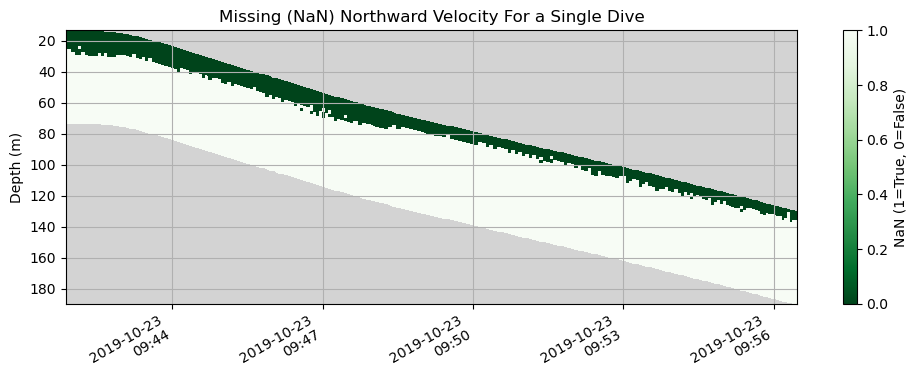

In [39]:
# Plotting NaN values in northward velocity to visualize data availability for a single dive
fig, ax1 = plt.subplots(figsize=(10, 4))

c = ax1.pcolormesh(time_grid, actual_depth_dive, masked_nan_NV, cmap='Greens_r', shading='auto')
ax1.invert_yaxis()
ax1.set_facecolor('lightgray')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Missing (NaN) Northward Velocity For a Single Dive')
fig.colorbar(c, ax=ax1, label='NaN (1=True, 0=False)')

# Format time axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.grid(True)
plt.show()

The glider picks up bottom-hit data as it reaches the end of the dive. Bottom-hit data is not trustworty data, and needs to be masked out in order to accurately calculate our velocity profiles. 

/tmp/ipykernel_1228/1890918334.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c1 = ax1.pcolormesh(time_grid, actual_depth_dive, NV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
/tmp/ipykernel_1228/1890918334.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c2 = ax2.pcolormesh(time_grid, actual_depth_dive, EV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)


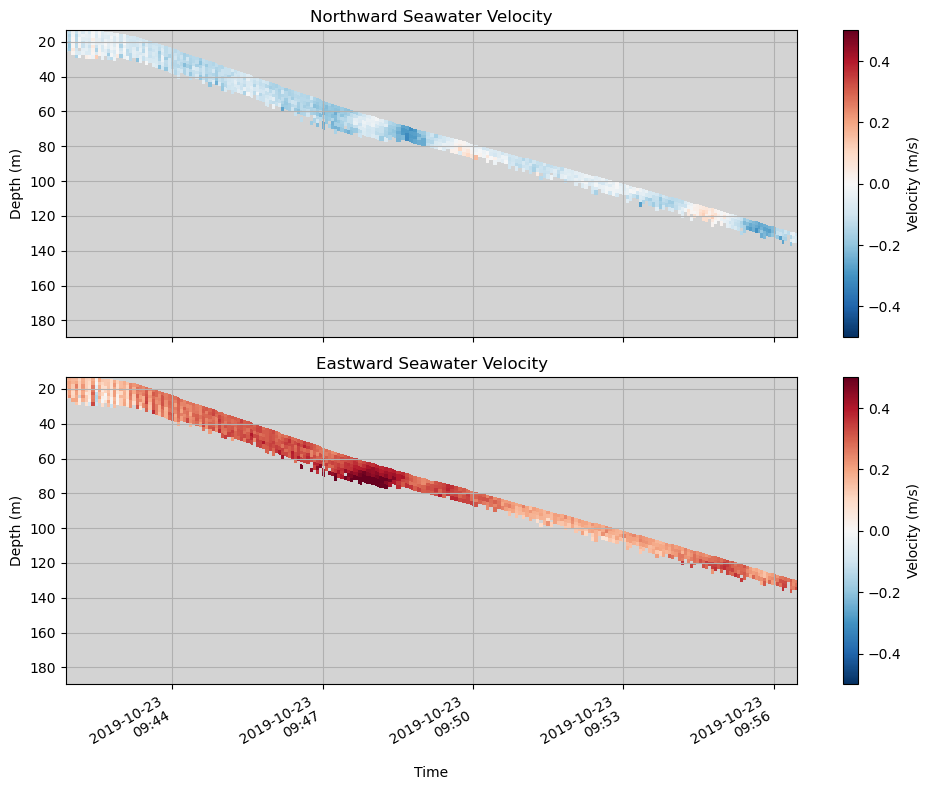

In [40]:
# Plotting velocity values for a single dive 

# Apply max depth mask (140 m) to velocities
NV_masked = np.where(actual_depth_dive <= max_depth_dive, NV_dive, np.nan)
EV_masked = np.where(actual_depth_dive <= max_depth_dive, EV_dive, np.nan)

# Plotting velocities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
vmax = 0.5
vmin = -0.5

# Northward velocity
c1 = ax1.pcolormesh(time_grid, actual_depth_dive, NV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
ax1.set_ylabel('Depth (m)')
ax1.set_title('Northward Seawater Velocity')
fig.colorbar(c1, ax=ax1, label='Velocity (m/s)')
ax1.invert_yaxis()
ax1.grid(True)
ax1.set_facecolor('lightgray')

# Eastward velocity
c2 = ax2.pcolormesh(time_grid, actual_depth_dive, EV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
ax2.set_xlabel('Time')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Eastward Seawater Velocity')
fig.colorbar(c2, ax=ax2, label='Velocity (m/s)')
ax2.invert_yaxis()
ax2.grid(True)
ax2.set_facecolor('lightgray')

# Time formatting
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

From our velocity data, we group the velocity measurements by depth and store the values in a new DataFrame. The mean and standard deviation of velocity values are then calculated by depth in these DataFrames.

In [41]:
# Flatten depth and velocity arrays and apply NaN filter
depth_flat_dive = actual_depth_dive.flatten()
north_vel_flat_dive = NV_dive.flatten()
east_vel_flat_dive = EV_dive.flatten()

valid_mask = ~np.isnan(north_vel_flat_dive) & ~np.isnan(east_vel_flat_dive) & ~np.isnan(depth_flat_dive)

depth_valid_dive = depth_flat_dive[valid_mask]
north_valid_dive = north_vel_flat_dive[valid_mask]
east_valid_dive = east_vel_flat_dive[valid_mask]

# Define bins and bin centers
bin_edges_dive = np.arange(0, 140, 4)  # binning every 4 meters to match mooring data
bin_centers_dive = (bin_edges_dive[:-1] + bin_edges_dive[1:]) / 2

# Categorize the depth values by bin 
depth_bins_valid_dive = pd.cut(depth_valid_dive, bins=bin_edges_dive)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_dive = pd.DataFrame({'depth_bin': depth_bins_valid_dive, 'velocity': north_valid_dive})
mean_north_dive = df_north_dive.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_dive = df_north_dive.groupby('depth_bin', observed=False)['velocity'].std()

df_east_dive = pd.DataFrame({'depth_bin': depth_bins_valid_dive, 'velocity': east_valid_dive})
mean_east_dive = df_east_dive.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_dive = df_east_dive.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_dive = mean_north_dive.values
east_profile_dive = mean_east_dive.values
std_north_profile_dive = std_north_dive.values
std_east_profile_dive = std_east_dive.values

Create plots of northward and eastward velocities measurements from the glider for this single dive

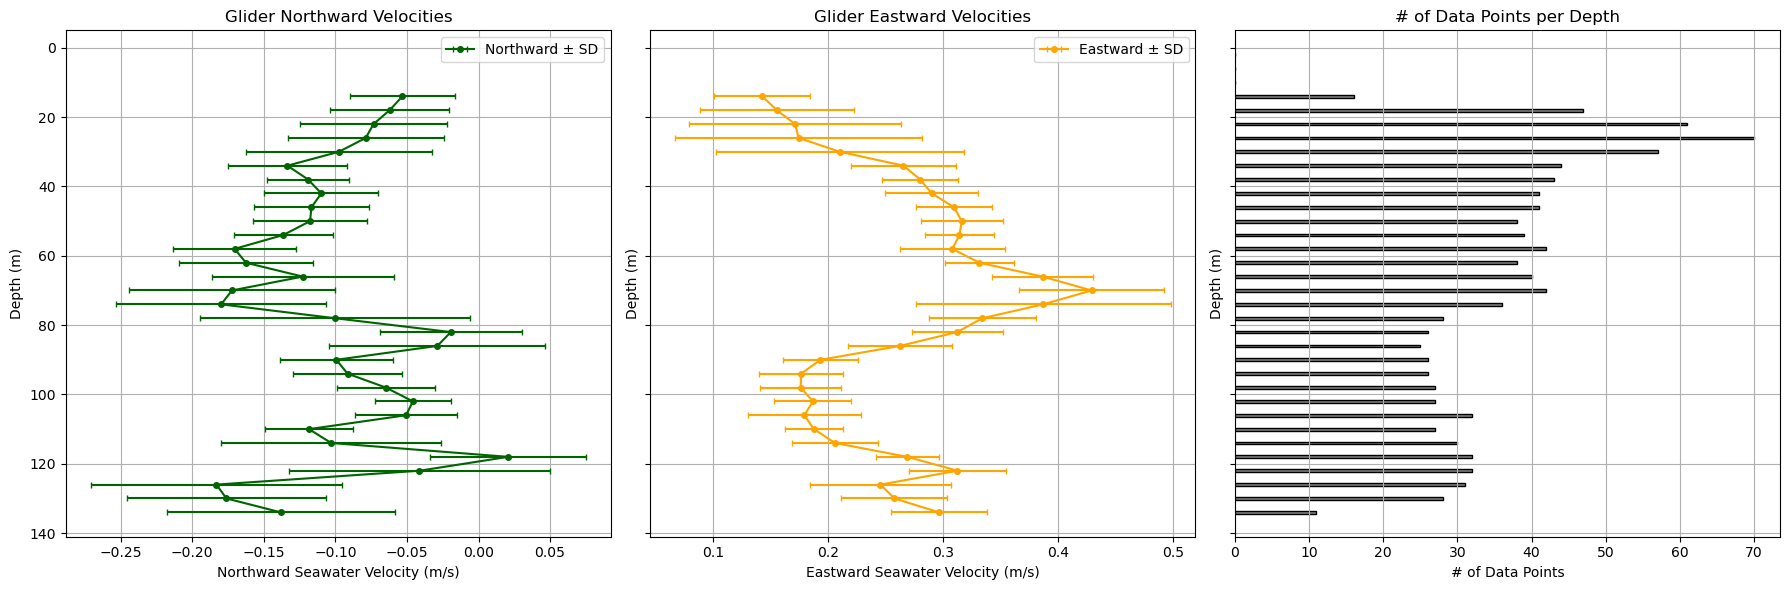

In [43]:
counts_per_bin_dive, _ = np.histogram(depth_valid_dive, bins=bin_edges_dive)

# Plot northward velocities with error bars representing standard deviation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
c1 = ax1.errorbar(north_profile_dive, bin_centers_dive, xerr=std_north_profile_dive, label='Northward ± SD', color='darkgreen', fmt='-o', capsize=2, markersize=4)
ax1.invert_yaxis()
ax1.set_xlabel('Northward Seawater Velocity (m/s)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Glider Northward Velocities')
ax1.grid(True)
ax1.legend()

# Plot eastward velocities with error bars representing standard deviation
c2 = ax2.errorbar(east_profile_dive, bin_centers_dive, xerr=std_east_profile_dive, label='Eastward ± SD', color='orange', fmt='-o', capsize=2, markersize=4)
ax2.invert_yaxis()
ax2.set_xlabel('Eastward Seawater Velocity (m/s)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Glider Eastward Velocities')
ax2.grid(True)
ax2.legend()

# Plot the number of valid data points per depth bin as a horizontal bar chart
c3 = ax3.barh(bin_centers_dive, counts_per_bin_dive, color='gray', edgecolor='black')
ax3.invert_yaxis()
ax3.set_xlabel('# of Data Points')
ax3.set_ylabel('Depth (m)')
ax3.set_title('# of Data Points per Depth')

plt.grid(True)
plt.tight_layout()
plt.show()

A histogram of data points per depth was plotted in order to justify using single dives for scientific purposes

The above plots are repeated for velocity profiles over an entire transect 

In [44]:
# Define the transect date range and subset the data
start_transect = '2019-10-05T02:42:00'
end_transect = '2019-10-08T01:47:00'
subset_transect = clean_glider.sel(time=slice(start_transect, end_transect))

# Extract other data 
NV_transect = subset_transect['northward_seawater_velocity']
EV_transect = subset_transect['eastward_seawater_velocity']
depth_transect = subset_transect['depth_from_pressure'].values

# creating 30 bins, each bin 2 meters deep
bin_depths_transect = np.arange(1, 60, 2)

# Calculating depth from bin depths and depth from pressure
actual_depth_transect = depth_transect[:, np.newaxis] + bin_depths_transect[np.newaxis, :]

bottom_hit_depths_transect = np.full(NV_transect.shape[0], np.inf)  # initialize with large depth
max_depth_transect = np.nanmax(actual_depth_transect)

# Creating NaN mask for velocities
nan_NV_transect = np.isnan(NV_transect)
nan_EV_transect = np.isnan(EV_transect)

# Filtering out bottom-hits for entire transect
for t in range(NV_transect.shape[0]):
    # Find indices where NV_transect is NaN (bottom hit)
    nan_indices_transect = np.where(nan_NV_transect[t])[0]
    if nan_indices_transect.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_transect = actual_depth_transect[t, nan_indices_transect]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_transect[t] = nan_depths_transect.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_transect = np.where(np.isinf(bottom_hit_depths_transect), max_depth_transect, bottom_hit_depths_transect)

# Initialize bottom mask same shape as actual_depth
bottom_mask_dynamic_transect = np.zeros_like(actual_depth_transect, dtype=bool)

for t in range(actual_depth_transect.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_transect[t] = actual_depth_transect[t] > bottom_hit_depths_transect[t]

# Combine with original NaN mask
masked_nan_dynamic_transect = np.logical_or(nan_NV_transect, bottom_mask_dynamic_transect)

# Applying mask to northward and eastward velocities
NV_transect_masked = NV_transect.where(~masked_nan_dynamic_transect)  # keep values where mask is False
EV_transect_masked = EV_transect.where(~masked_nan_dynamic_transect)

In [45]:
# Flatten values
depth_flat_transect = actual_depth_transect.flatten()
north_vel_flat_transect = NV_transect_masked.values.flatten()
east_vel_flat_transect = EV_transect_masked.values.flatten()

# Apply NaN filter
valid_mask_transect = ~np.isnan(north_vel_flat_transect) & ~np.isnan(east_vel_flat_transect) & ~np.isnan(depth_flat_transect)

depth_valid_transect = depth_flat_transect[valid_mask_transect]
north_valid_transect = north_vel_flat_transect[valid_mask_transect]
east_valid_transect = east_vel_flat_transect[valid_mask_transect]

# Define bins and bin centers
bin_edges_transect = np.arange(0, 160, 2)  # From 0 to 60m, every 2 meters
bin_centers_transect = (bin_edges_transect[:-1] + bin_edges_transect[1:]) / 2

# Bin depths
depth_bins_valid_transect = pd.cut(depth_valid_transect, bins=bin_edges_transect)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_transect = pd.DataFrame({'depth_bin': depth_bins_valid_transect, 'velocity': north_valid_transect})
mean_north_transect = df_north_transect.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_transect = df_north_transect.groupby('depth_bin', observed=False)['velocity'].std()

df_east_transect = pd.DataFrame({'depth_bin': depth_bins_valid_transect, 'velocity': east_valid_transect})
mean_east_transect = df_east_transect.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_transect = df_east_transect.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_transect = mean_north_transect.values
east_profile_transect = mean_east_transect.values
stdE_profile_transect = std_east_transect.values
stdN_profile_transect = std_north_transect.values

# Getting # of data points per depth
bin_edges_transect = np.arange(0, 160, 2)  # From 0 to 60m, every 2 meters
bin_centers_transect = (bin_edges_transect[:-1] + bin_edges_transect[1:]) / 2
counts_per_bin_transect, _ = np.histogram(depth_valid_transect, bins=bin_edges_transect)

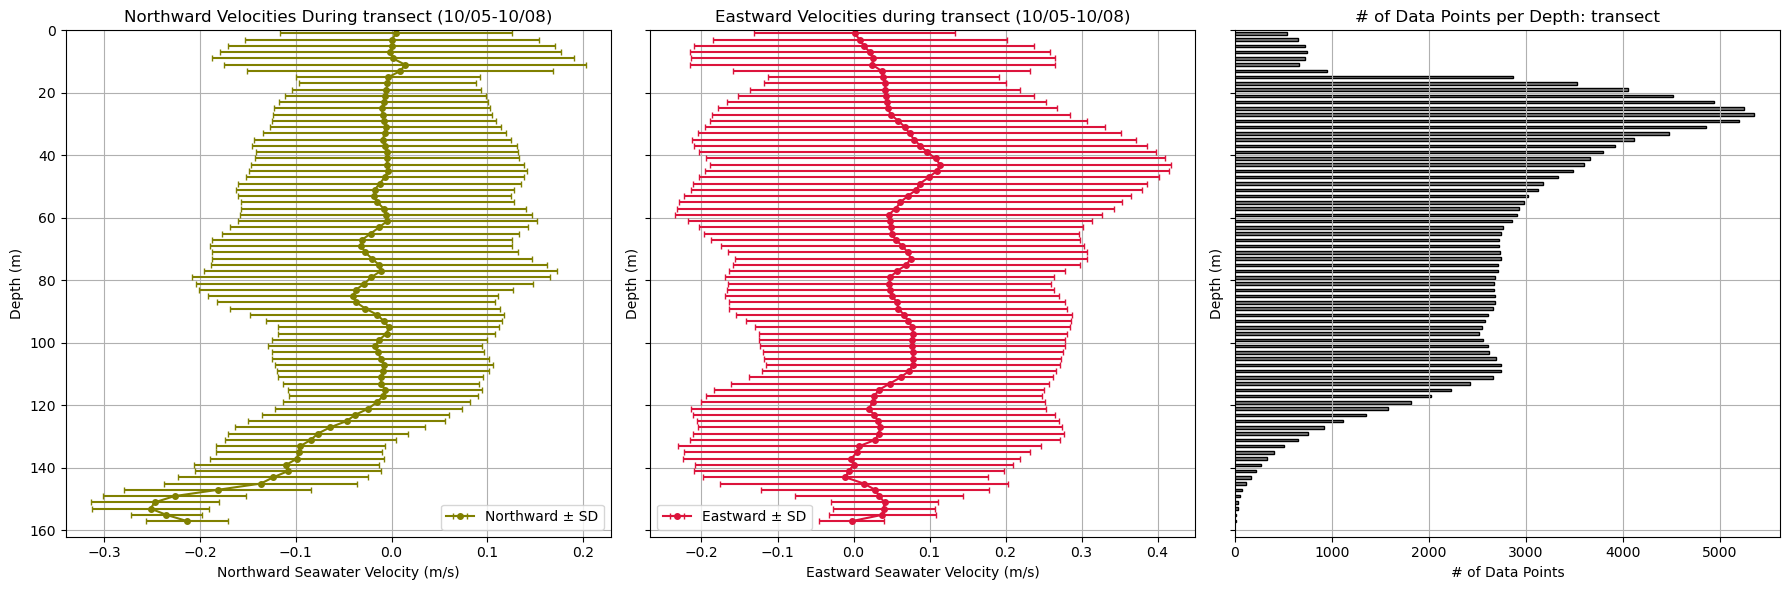

In [46]:
# Plotting profiles
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
c1 = ax1.errorbar(north_profile_transect, bin_centers_transect, xerr=stdN_profile_transect, label='Northward ± SD', color='olive', fmt='-o', capsize=2, markersize=4)
ax1.invert_yaxis()
ax1.set_xlabel('Northward Seawater Velocity (m/s)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Northward Velocities During transect (10/05-10/08)')
ax1.grid(True)
ax1.legend()

c2 = ax2.errorbar(east_profile_transect, bin_centers_transect, xerr=stdE_profile_transect, label='Eastward ± SD', color='crimson', fmt='-o', capsize=2, markersize=4)
ax2.invert_yaxis()
ax2.set_xlabel('Eastward Seawater Velocity (m/s)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Eastward Velocities during transect (10/05-10/08)')
ax2.grid(True)
ax2.legend()

c3 = ax3.barh(bin_centers_transect, counts_per_bin_transect, color='gray', edgecolor='black')
ax3.invert_yaxis()
ax3.set_xlabel('# of Data Points')
ax3.set_ylabel('Depth (m)')
ax3.set_ylim(162, 0)
ax3.set_title('# of Data Points per Depth: transect')

plt.grid(True)
plt.tight_layout()
plt.show()

## *Comparing Glider Profiles to Mooring Profiles*
In order to validate our glider velocity profiles, we need to compare them to the nearest mooring.

The glider passes nearby the Central Offshore Profiler Mooring on October 23rd, 2019 during one of its dives. The mooring creates profiles every 30 minutes, so we will be comparing the glider profile from the dive with the closest mooring profile. This temporal inconsistency causes differences that will be explored later.

We will be applying the same quality control to the mooring data to ensure accurate comparisons.

In [47]:
# Load in ADCP data from CP02PMCO D00013 (downloaded from OOINet)
CP02PMCO = xr.open_dataset("../data/raw/deployment0013_CP02PMCO-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth_20191023T090000-20191023T100000.nc")

sh: 1: getfattr: not found


In [48]:
# Apply QC mask to mooring data
qc_mask_PMCO = ~CP02PMCO['roll_qartod_results'].isin([4, 9])

PMCO_NV_clean = CP02PMCO['northward_seawater_velocity'].where(qc_mask_PMCO)
PMCO_EV_clean = CP02PMCO['eastward_seawater_velocity'].where(qc_mask_PMCO)

masked_velocities = CP02PMCO.copy()

masked_velocities['northward_seawater_velocity'] = PMCO_NV_clean
masked_velocities['eastward_seawater_velocity'] = PMCO_EV_clean

# Create new dataset with "clean" velocities
masked_velocities.to_netcdf("../data/processed/CP02PMCO.dep13.masked_velocities.nc")

In [49]:
# Open quality-controlled dataset
masked_PMCO = xr.open_dataset("../data/processed/CP02PMCO.dep13.masked_velocities.nc")

sh: 1: getfattr: not found


In [50]:
# Extract data from the CP02PMCO ADCP measurement closest in time to the glider profile
# OOINet data exports are categorized by observations (OBS)
# The closest measurements occurs at 2019-10-23T09:00:00 UTC, which is the third set of observations in the data
PMCO_NV = masked_PMCO['northward_seawater_velocity'].isel(obs=2)
PMCO_EV = masked_PMCO['eastward_seawater_velocity'].isel(obs=2)
PMCO_depth = masked_PMCO['bin_depths'].isel(obs=2)

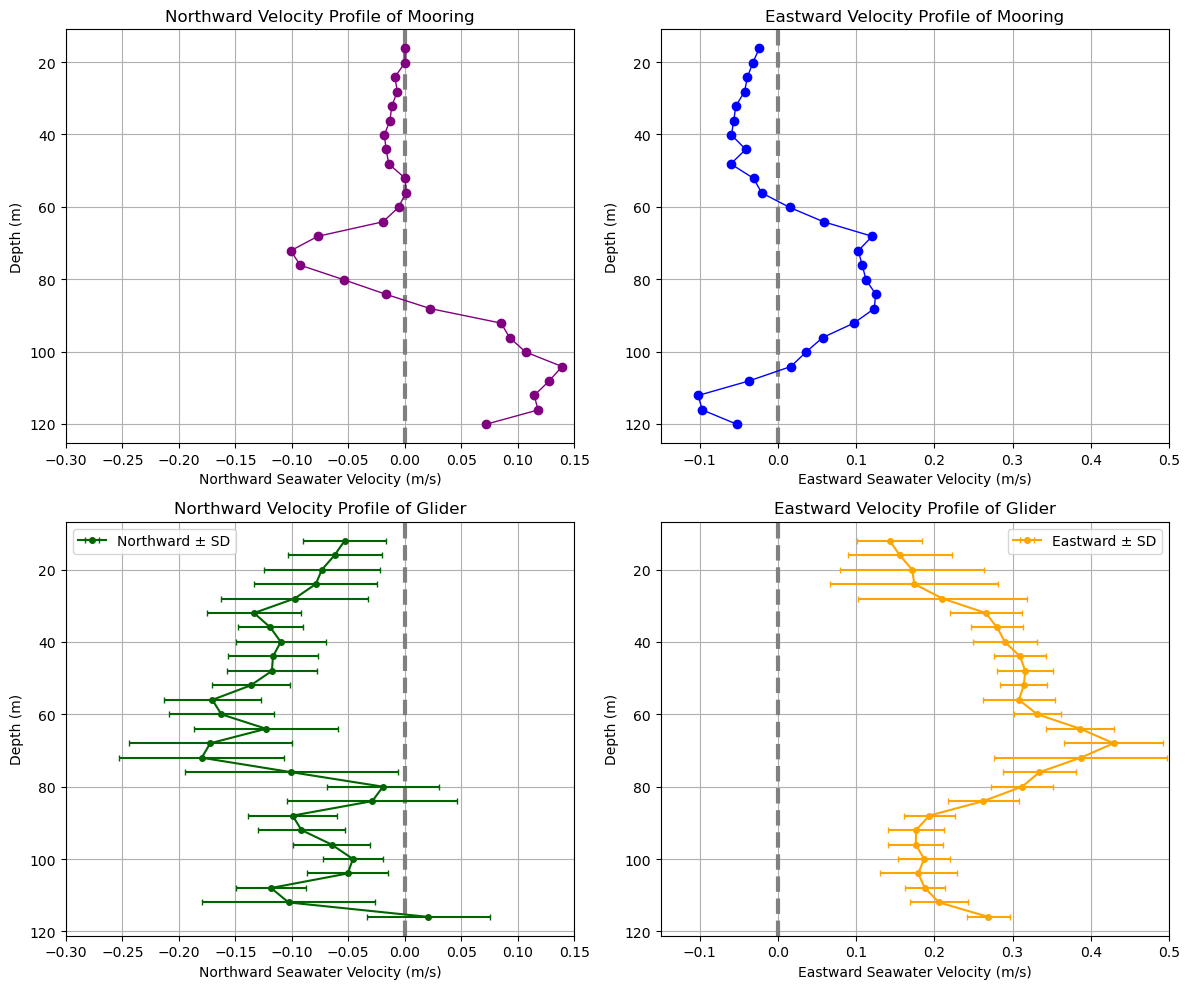

In [51]:
# Plot glider and mooring profiles
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

for ax in [ax1, ax2, ax3, ax4]:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=3)

c1 = ax1.plot(PMCO_NV[0:27], PMCO_depth[0:27], color='purple', linestyle='-', marker='o', lw = 1, markersize=6)
ax1.set_xlabel("Northward Seawater Velocity (m/s)")
ax1.set_xlim(-0.3, 0.15)
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()
ax1.set_title("Northward Velocity Profile of Mooring")
ax1.grid(True) 

c2 = ax2.plot(PMCO_EV[0:27], PMCO_depth[0:27], color='blue', linestyle='-', marker='o', lw=1, markersize=6)
ax2.set_xlabel("Eastward Seawater Velocity (m/s)")
ax2.set_xlim(-0.15, 0.5)
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()
ax2.set_title("Eastward Velocity Profile of Mooring")
ax2.grid(True)

c3 = ax3.errorbar(north_profile_dive[0:30], bin_edges_dive[0:30], xerr=std_north_profile_dive[0:30], label='Northward ± SD', color='darkgreen', fmt='-o', capsize=2, markersize=4)
ax3.invert_yaxis()
ax3.set_xlabel('Northward Seawater Velocity (m/s)')
ax3.set_xlim(-0.3, 0.15)
ax3.set_ylabel('Depth (m)')
ax3.set_title('Northward Velocity Profile of Glider')
ax3.grid(True)
ax3.legend()

c4 = ax4.errorbar(east_profile_dive[0:30], bin_edges_dive[0:30], xerr=std_east_profile_dive[0:30], label='Eastward ± SD', color='orange', fmt='-o', capsize=2, markersize=4)
ax4.invert_yaxis()
ax4.set_xlabel('Eastward Seawater Velocity (m/s)')
ax4.set_xlim(-0.15, 0.5)
ax4.set_ylabel('Depth (m)')
ax4.set_title('Eastward Velocity Profile of Glider')
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

#### *Removing Bottom Track Velocities*
Removing the glider's speed through the water is very important for this comparison, as it removes any bias in the velocities caused by glider motion. Unfortunately, glider speed was inconsistent over the course of dives and transects. For our analysis of the how the bottom-track velocities impact the data, we removed 0.25 m/s from eastward velocity values, while kept northward velocities untouched.

The next step in analysis is to make a difference profile.

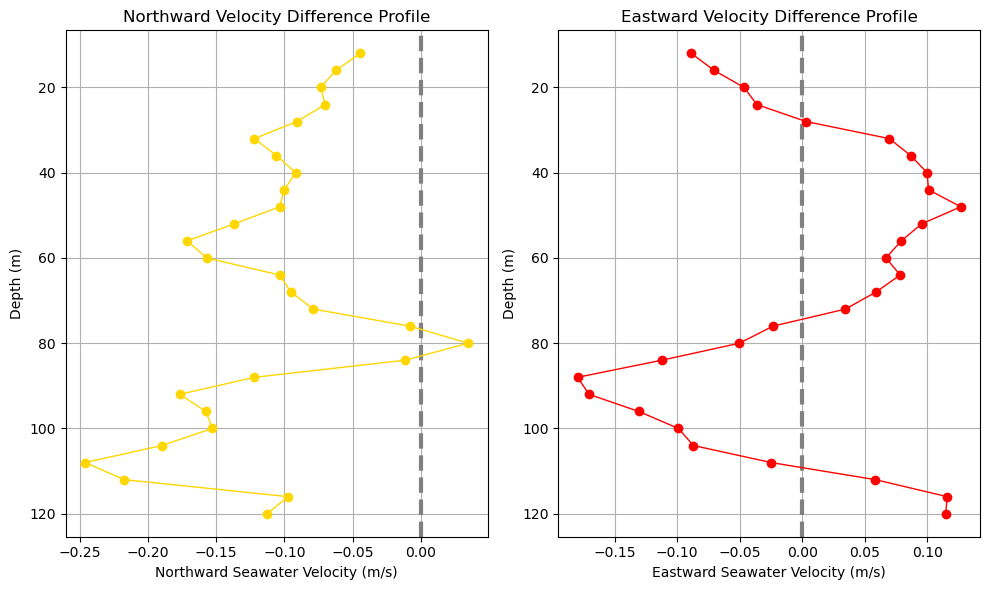

In [52]:
# Creating a difference profile
NV_diff = north_profile_dive[1:31] - PMCO_NV[0:30][::-1]    # putting mooring values in ascending order
EV_diff = (east_profile_dive[1:31] - 0.25) - PMCO_EV[0:30][::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
for ax in [ax1, ax2]:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=3)

c1 = ax1.plot(NV_diff, bin_edges_dive[1:31], color='gold', linestyle='-', marker='o', lw = 1, markersize=6)
ax1.set_xlabel("Northward Seawater Velocity (m/s)")
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()
ax1.set_title("Northward Velocity Difference Profile")
ax1.grid(True) 

c2 = ax2.plot(EV_diff, bin_edges_dive[1:31], color='red', linestyle='-', marker='o', lw=1, markersize=6)
ax2.set_xlabel("Eastward Seawater Velocity (m/s)")
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()
ax2.set_title("Eastward Velocity Difference Profile")
ax2.grid(True)

plt.tight_layout()
plt.show()

**Comparison of the profiles reveals that spatial and temporal differences betweenthe glider and mooring exist. The shapes and characteristics of the instruments are similar, but differences are evident. From this, we infer that the glider has an instrumentation error of roughly 0.05 m/s, which will be applied into the profiles for future analysis.**

## *Evaluating Shelf-Break Frontal Dynamics*
The Pioneer Array resided along the New England Shelf break before being relocated to the Mid Atlantic Bite. The goal of the array was to study shelf-break frontal dynamics and exchange off the shore of New England. 

Using our velocity profiles, we will evaluate frontal processes.

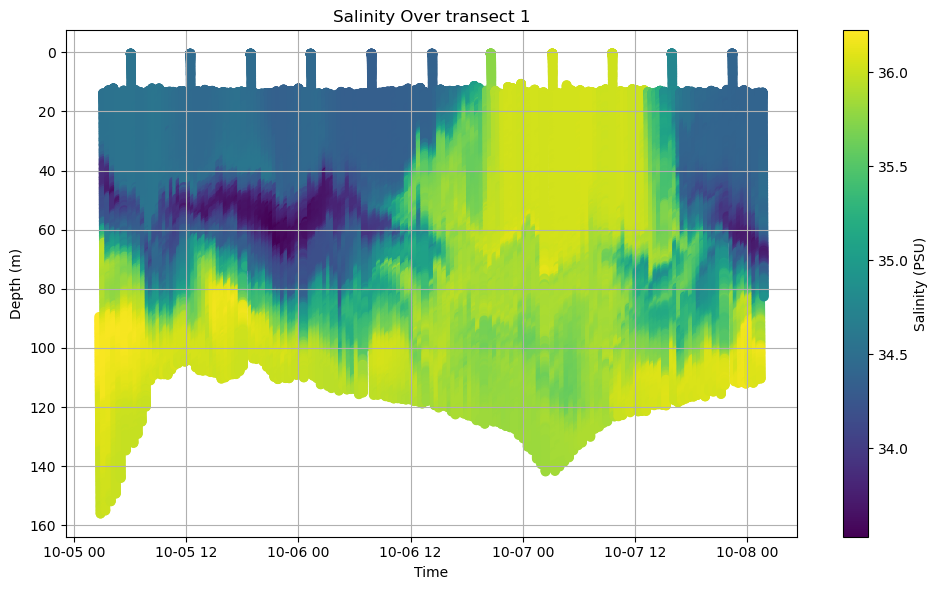

In [53]:
# Plotting glider salinity measurements over a transect
# Select a transect
start_transect = '2019-10-05T02:42:00'
end_transect = '2019-10-08T01:47:00'
subset_transect = clean_glider.sel(time=slice(start_transect, end_transect))

times_transect = pd.to_datetime(subset_transect['time'].values).to_pydatetime()

# Extract salinity data
salinity_transect = subset_transect['ctd_salinity'].values
depth_transect = subset_transect['depth_from_pressure'].values

# Plot salinity
plt.figure(figsize=(10, 6))
sc = plt.scatter(times_transect, depth_transect, c=salinity_transect, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(sc, label='Salinity (PSU)')
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Salinity Over transect 1')
plt.tight_layout()
plt.grid(True)
plt.show()

**This particular transect is chosen due to the salt-water intrusion occurring near October 7th. To investigate frontal dynamics, velocity profiles will be made from a 12-hour period during the intrusion event and before the event (when normal vertical structure exists). The comparison of these profiles can potentially tell us about the state of the shelf-break saliity front.**

In [54]:
# Creating velocity profiles during the intrusion
salt_start = '2019-10-07T00:00:00'
salt_end = '2019-10-07T12:00:00'
salt_subset = clean_glider.sel(time=slice(salt_start, salt_end))
times_salt = pd.to_datetime(salt_subset['time'].values).to_pydatetime()

# Extracting other data
NV_salt = salt_subset['northward_seawater_velocity']
EV_salt = salt_subset['eastward_seawater_velocity']
salinity_salt = salt_subset['ctd_salinity'].values
depth_salt = salt_subset['depth_from_pressure'].values

# 30 bins, each bin 2 meters deep
bin_depths_salt = np.arange(1, 60, 2)

# Actual depth follows pressure
actual_depth_salt = depth_salt[:, np.newaxis] + bin_depths_salt[np.newaxis, :]
bottom_hit_depths_salt = np.full(NV_salt.shape[0], np.inf)  # initialize with large depth
max_depth_salt = np.nanmax(actual_depth_salt)

# Creating NaN mask for velocities
nan_NV_salt = np.isnan(NV_salt)
nan_EV_salt = np.isnan(EV_salt)

# Filtering out bottom-hits for entire transect
for t in range(NV_salt.shape[0]):
    # Find indices where NV is NaN (bottom hit)
    nan_indices_salt = np.where(nan_NV_salt[t])[0]
    if nan_indices_salt.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_salt = actual_depth_salt[t, nan_indices_salt]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_salt[t] = nan_depths_salt.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_salt = np.where(np.isinf(bottom_hit_depths_salt), max_depth_salt, bottom_hit_depths_salt)

# Initialize bottom mask same shape as actual_depth
bottom_mask_dynamic_salt = np.zeros_like(actual_depth_salt, dtype=bool)

for t in range(actual_depth_salt.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_salt[t] = actual_depth_salt[t] > bottom_hit_depths_salt[t]

# Combine with original NaN mask
masked_nan_NV_dynamic_salt = np.logical_or(nan_NV_salt, bottom_mask_dynamic_salt)

# Identify diving times
depth_change_salt = np.diff(depth_salt, prepend=np.nan)
is_diving_salt = depth_change_salt > 0

# Expand to full 2D shape to match actual_depth_salt or NV_salt
is_diving_2d_salt = np.repeat(is_diving_salt[:, np.newaxis], NV_salt.shape[1], axis=1)

# Apply combined mask: bottom hit + ascending
combined_mask_salt = np.logical_or(masked_nan_NV_dynamic_salt, ~is_diving_2d_salt)

NV_salt_masked = NV_salt.where(~combined_mask_salt)
EV_salt_masked = EV_salt.where(~combined_mask_salt) - 0.25

# Flatten values
depth_flat_salt = actual_depth_salt.flatten()
north_vel_flat_salt = NV_salt_masked.values.flatten()
east_vel_flat_salt = EV_salt_masked.values.flatten()

# Apply NaN filter
valid_mask_salt = ~np.isnan(north_vel_flat_salt) & ~np.isnan(depth_flat_salt) & ~np.isnan(east_vel_flat_salt)

depth_valid_salt = depth_flat_salt[valid_mask_salt]
north_valid_salt = north_vel_flat_salt[valid_mask_salt]
east_valid_salt = east_vel_flat_salt[valid_mask_salt]

# Define bins and bin centers
bin_edges_salt = np.arange(0, 152, 2)  # From 0 to 60m, every 2 meters
bin_centers_salt = (bin_edges_salt[:-1] + bin_edges_salt[1:]) / 2

# Bin depths
depth_bins_valid_salt = pd.cut(depth_valid_salt, bins=bin_edges_salt)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_salt = pd.DataFrame({'depth_bin': depth_bins_valid_salt, 'velocity': north_valid_salt})
mean_north_salt = df_north_salt.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_salt = df_north_salt.groupby('depth_bin', observed=False)['velocity'].std()

df_east_salt = pd.DataFrame({'depth_bin': depth_bins_valid_salt, 'velocity': east_valid_salt})
mean_east_salt = df_east_salt.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_salt = df_east_salt.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_salt = mean_north_salt.values
stdN_profile_salt = std_north_salt.values

east_profile_salt = mean_east_salt.values
stdE_profile_salt = std_east_salt.values

error_north_salt = np.sqrt((stdN_profile_salt ** 2) +(0.05 ** 2))
error_east_salt = np.sqrt((stdE_profile_salt ** 2) + (0.05 ** 2))

In [55]:
# Creating a profile for normal shelf conditions
shelf_start = '2019-10-05T00:00:00'
shelf_end = '2019-10-05T12:00:00'
shelf_subset = clean_glider.sel(time=slice(shelf_start, shelf_end))

times_shelf = pd.to_datetime(shelf_subset['time'].values).to_pydatetime()

# Extracting other data
NV_shelf = shelf_subset['northward_seawater_velocity']
EV_shelf = shelf_subset['eastward_seawater_velocity']
salinity_shelf = shelf_subset['ctd_salinity'].values
depth_shelf = shelf_subset['depth_from_pressure'].values

# 30 bins, each bin 2 meters deep
bin_depths_shelf = np.arange(1, 60, 2)

# Actual depth follows pressure
actual_depth_shelf = depth_shelf[:, np.newaxis] + bin_depths_shelf[np.newaxis, :]

bottom_hit_depths_shelf = np.full(NV_shelf.shape[0], np.inf)  # initialize with large depth
max_depth_shelf = np.nanmax(actual_depth_shelf)

# Creating NaN mask for velocities
nan_NV_shelf = np.isnan(NV_shelf)
nan_EV_shelf = np.isnan(EV_shelf)

# Filtering out bottom-hits for entire transect
for t in range(NV_shelf.shape[0]):
    # Find indices where NV is NaN (bottom hit)
    nan_indices_shelf = np.where(nan_NV_shelf[t])[0]
    if nan_indices_shelf.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_shelf = actual_depth_shelf[t, nan_indices_shelf]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_shelf[t] = nan_depths_shelf.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_shelf = np.where(np.isinf(bottom_hit_depths_shelf), max_depth_shelf, bottom_hit_depths_shelf)

# Initialize bottom mask same shape as actual_depth
bottom_mask_dynamic_shelf = np.zeros_like(actual_depth_shelf, dtype=bool)

for t in range(actual_depth_shelf.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_shelf[t] = actual_depth_shelf[t] > bottom_hit_depths_shelf[t]

# Combine with original NaN mask
masked_nan_NV_dynamic_shelf = np.logical_or(nan_NV_shelf, bottom_mask_dynamic_shelf)

# Identify diving times
depth_change_shelf = np.diff(depth_shelf, prepend=np.nan)
is_diving_shelf = depth_change_shelf > 0

# Expand to full 2D shape to match actual_depth_salt or NV_salt
is_diving_2d_shelf = np.repeat(is_diving_shelf[:, np.newaxis], NV_shelf.shape[1], axis=1)

# Apply combined mask: bottom hit + ascending
combined_mask_shelf = np.logical_or(masked_nan_NV_dynamic_shelf, ~is_diving_2d_shelf)

NV_shelf_masked = NV_shelf.where(~combined_mask_shelf)
EV_shelf_masked = EV_shelf.where(~combined_mask_shelf) - 0.25

# Flatten values
depth_flat_shelf = actual_depth_shelf.flatten()
north_vel_flat_shelf = NV_shelf_masked.values.flatten()
east_vel_flat_shelf = EV_shelf_masked.values.flatten()

# Apply NaN filter
valid_mask_shelf = ~np.isnan(north_vel_flat_shelf) & ~np.isnan(depth_flat_shelf) & ~np.isnan(east_vel_flat_shelf)

depth_valid_shelf = depth_flat_shelf[valid_mask_shelf]
north_valid_shelf = north_vel_flat_shelf[valid_mask_shelf]
east_valid_shelf = east_vel_flat_shelf[valid_mask_shelf]

# Define bins and bin centers
bin_edges_shelf = np.arange(0, 174, 2)  # From 0 to 60m, every 2 meters
bin_centers_shelf = (bin_edges_shelf[:-1] + bin_edges_shelf[1:]) / 2

# Bin depths
depth_bins_valid_shelf = pd.cut(depth_valid_shelf, bins=bin_edges_shelf)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_shelf = pd.DataFrame({'depth_bin': depth_bins_valid_shelf, 'velocity': north_valid_shelf})
mean_north_shelf = df_north_shelf.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_shelf = df_north_shelf.groupby('depth_bin', observed=False)['velocity'].std()

df_east_shelf = pd.DataFrame({'depth_bin': depth_bins_valid_shelf, 'velocity': east_valid_shelf})
mean_east_shelf = df_east_shelf.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_shelf = df_east_shelf.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_shelf = mean_north_shelf.values
stdN_profile_shelf = std_north_shelf.values

east_profile_shelf = mean_east_shelf.values
stdE_profile_shelf = std_east_shelf.values

error_north_shelf = np.sqrt((stdN_profile_shelf ** 2) +(0.05 ** 2))
error_east_shelf = np.sqrt((stdE_profile_shelf ** 2) + (0.05 ** 2))

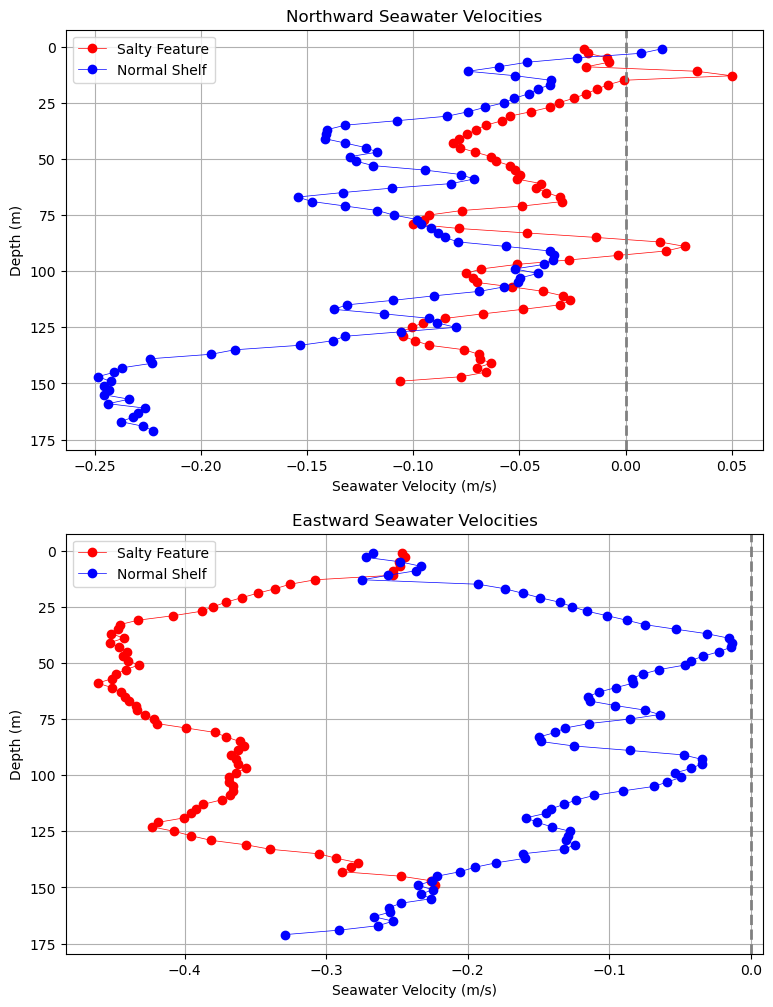

In [56]:
# Plotting the northward velocities and eastward velocities together
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,12))
x1 = north_profile_salt
x2 = north_profile_shelf
x3 = east_profile_salt
x4 = east_profile_shelf
y1 =  bin_centers_salt
y2 = bin_centers_shelf

c1 = ax1.plot(x1, y1, label='Salty Feature', color='red', linewidth=0.5, marker='o')
ax1.plot(x2, y2, label='Normal Shelf', color='blue', linewidth=0.5, marker='o')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=2)
ax1.set_ylabel('Depth (m)')
ax1.invert_yaxis()
ax1.set_xlabel('Seawater Velocity (m/s)')
ax1.set_title('Northward Seawater Velocities')
ax1.grid(True)
ax1.legend(loc='best')

c2 = ax2.plot(x3, y1, label='Salty Feature', color='red', marker='o', linewidth=0.5)
ax2.plot(x4, y2, label='Normal Shelf', color='blue', marker='o', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=2)
ax2.set_ylabel('Depth (m)')
ax2.invert_yaxis()
ax2.set_xlabel('Seawater Velocity (m/s)')
ax2.set_title('Eastward Seawater Velocities')
ax2.grid(True)
ax2.legend(loc='best')

plt.show()

**During the salt-water intrusion event, water velocities have a more northwestward flow. This may be indicative of a frontal meander. However, more data (like satellite SST data) would be needed to confirm this. Also, other transects, seasons, and gliders would need to be inspected to see if this signal is significant or not.**

## *Conclusions*

Quality control was successfully applied to the glider velocity data. This allowed us to:
- Create depth-averaged velocity profiles of individual dives and over transects
- Compare glider velocity data to mooring data
- Possibly identify a plausible frontal meander of the shelf-break front